# Comparison between empirical and predicted pipeline similarities

In [102]:
import os
import pickle
import fastdtw
import Levenshtein
import numpy as np
import pandas as pd
import ptitprince as pt
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MultiLabelBinarizer

wd = os.getcwd()

file_paths = [f"{wd}/multiverse/multiverse_pipelines/results/universe_{i}.pkl" for i in range(1, 17)]
gcn_data = f"{wd}/multiverse/data/graph_and_embeddings.pkl" 
pipeline_path = f"{wd}/multiverse/data/pipelines_multiverse.xlsx"

The empirical similarity is estimated for 14 different pipelines as defined in the multiverse analysis in `multiverse/run_multiverse.py`. It becomes clear, that some pipelines produce similar results, while some pipelines show substatially different results:

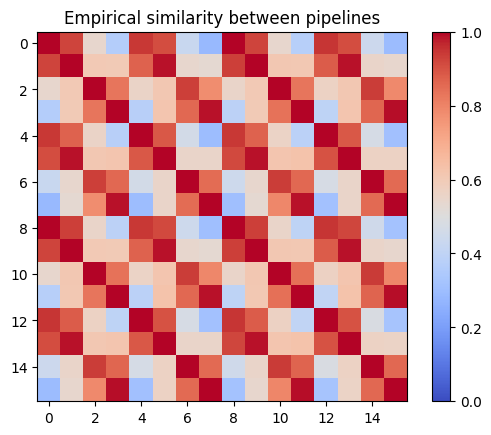

In [103]:
universes_data = []
for file_path in file_paths:
    with open(file_path, 'rb') as file:
        universe = pickle.load(file)
        universes_data.append(list(universe.values()))

empirical_similarity = np.corrcoef(np.array(universes_data))

plt.figure()
plt.imshow(empirical_similarity, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title('Empirical similarity between pipelines')
plt.show()

Data from the trained GCN network is loaded:

In [104]:
with open(gcn_data, 'rb') as file:
    loaded_variables = pickle.load(file)

# Load embeddings
G = loaded_variables["G"]
G_nx = loaded_variables["G_nx"]
nodes = loaded_variables["nodes"]
node_features = loaded_variables["node_features"]
embeddings = loaded_variables["embeddings"]
embeddings_dict = {label: emb for label, emb in zip(nodes, embeddings)}

# Load pipelines
pipeline_df = pd.read_excel(pipeline_path, index_col=0)
pipelines = pipeline_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()

Predicted pipeline dissimilarity:

In [105]:
def dtw_reduce(data):
    num_features, _ = data.shape
    reference_sequence = np.mean(data, axis=0)
    dtw_distances = np.zeros(num_features)

    for i in range(num_features):
        distance, _ = fastdtw.fastdtw(data[i], reference_sequence)
        dtw_distances[i] = distance

    return dtw_distances

# GCN-DTW
pipeline_embeddings_dtw = []
for pipeline in pipelines:
        pipeline_embs = [embeddings_dict[node] for node in pipeline if node in embeddings_dict]
        if pipeline_embs:
            pipeline_embs = np.array(pipeline_embs)
            pipeline_embs = np.transpose(pipeline_embs)
            joint_embedding = dtw_reduce(pipeline_embs)
            pipeline_embeddings_dtw.append(joint_embedding)

joint_embeddings_dtw = pd.DataFrame(pipeline_embeddings_dtw)

dissimilarity_matrix = squareform(pdist(joint_embeddings_dtw, metric='euclidean'))
min_val = np.min(dissimilarity_matrix)
max_val = np.max(dissimilarity_matrix)
scaled_dissimilarity_matrix = (dissimilarity_matrix - min_val) / (max_val - min_val)
embedding_similarity_dtw = 1 - scaled_dissimilarity_matrix

# Levenshtein distance
n = len(pipelines)
levenshtein_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            levenshtein_distance[i, j] = Levenshtein.distance(pipelines[i], pipelines[j])

min_val = np.min(levenshtein_distance)
max_val = np.max(levenshtein_distance)
scaled_levenshtein_distance = (levenshtein_distance - min_val) / (max_val - min_val)
levenshtein_similarity = 1 - scaled_levenshtein_distance

# Hamming distance
n = len(pipelines)
hamming_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            hamming_distance[i, j] = Levenshtein.hamming(pipelines[i], pipelines[j])

min_val = np.min(hamming_distance)
max_val = np.max(hamming_distance)
scaled_hamming_distance = (hamming_distance - min_val) / (max_val - min_val)
hamming_similarity = 1 - scaled_hamming_distance

# Jaccard distance
mlb = MultiLabelBinarizer()
pipeline_binary = mlb.fit_transform(pipelines)
jaccard_similarity = 1 - pairwise_distances(pipeline_binary, metric="jaccard")

/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Comparing the predicted similarities with the empirical results from the multiverse analysis:

In [106]:
empirical_upper = empirical_similarity[np.triu_indices_from(empirical_similarity, k=1)]
gcn_upper = embedding_similarity_dtw[np.triu_indices_from(embedding_similarity_dtw, k=1)]
levenshtein_upper = levenshtein_similarity[np.triu_indices_from(levenshtein_similarity, k=1)]
hamming_upper = hamming_similarity[np.triu_indices_from(hamming_similarity, k=1)]
jaccard_upper = jaccard_similarity[np.triu_indices_from(jaccard_similarity, k=1)]

similarity_data = pd.DataFrame({
    'Empirical': empirical_upper,
    'GCN-DTW': gcn_upper,
    'Jaccard': jaccard_upper,
    'Levenshtein': levenshtein_upper,
    'Hamming': hamming_upper

})

# Calculate absolute errors
absolute_errors = {
    'GCN-DTW': np.abs(similarity_data['Empirical'] - similarity_data['GCN-DTW']),
    'Levenshtein': np.abs(similarity_data['Empirical'] - similarity_data['Levenshtein']),
    'Jaccard': np.abs(similarity_data['Empirical'] - similarity_data['Jaccard']),
    'Hamming': np.abs(similarity_data['Empirical'] - similarity_data['Hamming']),
}

absolute_errors_df = pd.DataFrame(absolute_errors)
absolute_errors_df_melted = absolute_errors_df.melt(var_name='Method', value_name='Absolute Error') # melt the DataFrame for visualization


Create a raincloud plot for the results:

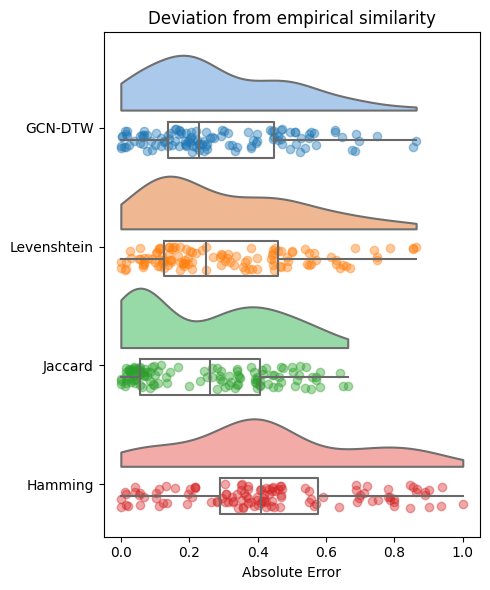


Median Absolute Errors:
 GCN-DTW        0.228062
Levenshtein    0.249785
Jaccard        0.259953
Hamming        0.410503
dtype: float64


In [107]:
data = absolute_errors_df_melted.copy()

METHOD = ["GCN-DTW", "Levenshtein", "Jaccard", "Hamming"]
SHIFT = 0.1
POSITIONS = [0 + SHIFT, 1 + SHIFT, 2 + SHIFT, 3 + SHIFT]

boxplot_data = [data[data["Method"] == method]["Absolute Error"].values for method in METHOD]

medianprops = {"linewidth": 1.5, "color": "#696969", "solid_capstyle": "butt"}
boxprops = {"linewidth": 1.5, "color": "#696969"}

fig, ax = plt.subplots(figsize=(5, 6))

# Plot the half-violin plots
pt.half_violinplot(x="Absolute Error", y="Method", inner=None, data=data, width=1, ax=ax, cut=0, palette="pastel")

# Scatter points
for i, method in enumerate(METHOD):
    method_data = data[data["Method"] == method]
    y = i + np.random.uniform(high=0.2, size=len(method_data))  # Add jitter
    x = method_data["Absolute Error"]
    ax.scatter(x, y, alpha=0.4)

# Boxplots
ax.boxplot(
    boxplot_data,
    vert=False,
    positions=POSITIONS,
    widths=0.3, 
    manage_ticks=False,
    showfliers=False,
    showcaps=False,
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops
)

# Axes and labels
ax.set_xlim(-0.05,1.05)
ax.set_xlabel("Absolute Error", fontsize=10)
ax.set_ylabel("")
ax.set_title("Deviation from empirical similarity", fontsize=12)
ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

# Calculate median absollute errors
median_errors = absolute_errors_df.median()
print("\nMedian Absolute Errors:\n", median_errors)